<a href="https://colab.research.google.com/github/shubham-bhagwat/N1Health_Challenge/blob/main/N1Health_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **N1 Health Data Challenge**
### *Answering Key Questions and Analyzing Client Data*





In [1]:
import sqlite3
import csv
import pandas as pd

In [2]:
# connect to the SQLite database
conn = sqlite3.connect('interview.db')
cur = conn.cursor()


# **Step 1:** Create a table called std_member_info to aggregate and standardize the five member rosters

In [3]:
cur.execute('''
    CREATE TABLE std_member_info AS
    SELECT
        Person_Id AS member_id,
        First_Name AS member_first_name,
        Last_Name AS member_last_name,
        dob AS date_of_birth,
        street_address AS main_address,
        city,
        state,
        zip,
        payer
    FROM
        roster_1
    UNION ALL
    SELECT
        Person_Id,
        First_Name,
        Last_Name,
        dob,
        street_address ,
        city,
        state,
        zip,
        payer
    FROM
        roster_2
    UNION ALL
    SELECT
        Person_Id,
        First_Name,
        Last_Name,
        dob,
        street_address ,
        city,
        state,
        zip,
        payer
    FROM
        roster_3
    UNION ALL
    SELECT
        Person_Id,
        First_Name,
        Last_Name,
        dob,
        street_address,
        city,
        state,
        zip,
        payer
    FROM
        roster_4
    UNION ALL
    SELECT
        Person_Id,
        First_Name,
        Last_Name,
        dob,
        street_address,
        city,
        state,
        zip,
        payer
    FROM
        roster_5
    WHERE
        eligibility_start_date <= '2022-04-30'
        AND eligibility_end_date >= '2022-04-01'
''')

cur.execute('''
    SELECT
        COUNT(*) AS total_members
    FROM
        std_member_info
''')
total_mambers = cur.fetchone()

# print the summary statistics
print('Total Members:', total_mambers[0])

Total Members: 129165


# **Step 2:** Create summary statistics on the std_member_info table

In [4]:
cur.execute('''
    SELECT * FROM std_member_info WHERE  member_id IS NULL OR
        member_first_name IS NULL OR
        member_last_name IS NULL OR
        date_of_birth IS NULL OR
        main_address IS NULL OR
        city IS NULL OR
        state IS NULL OR
        zip IS NULL OR
        payer IS NULL
    
''')
null_val = cur.fetchall()
print('Rows having Null Values', null_val)

Rows having Null Values []


In [5]:
cur.execute('''
    SELECT * FROM roster_1 WHERE Person_Id IS NULL OR
        First_Name IS NULL OR
        Last_Name IS NULL OR
        dob IS NULL OR
        age IS NULL OR
        street_address IS NULL OR
        city IS NULL OR
        state IS NULL OR
        zip IS NULL OR
        payer IS NULL
    UNION ALL
    SELECT * FROM roster_2 WHERE Person_Id IS NULL OR
        First_Name IS NULL OR
        Last_Name IS NULL OR
        dob IS NULL OR
        age IS NULL OR
        street_address IS NULL OR
        city IS NULL OR
        state IS NULL OR
        zip IS NULL OR
        payer IS NULL
    UNION ALL
    SELECT * FROM roster_3 WHERE Person_Id IS NULL OR
        First_Name IS NULL OR
        Last_Name IS NULL OR
        dob IS NULL OR
        age IS NULL OR
        street_address IS NULL OR
        city IS NULL OR
        state IS NULL OR
        zip IS NULL OR
        payer IS NULL
    UNION ALL
    SELECT * FROM roster_4 WHERE Person_Id IS NULL OR
        First_Name IS NULL OR
        Last_Name IS NULL OR
        dob IS NULL OR
        age IS NULL OR
        street_address IS NULL OR
        city IS NULL OR
        state IS NULL OR
        zip IS NULL OR
        payer IS NULL
    UNION ALL
    SELECT * FROM roster_5 WHERE Person_Id IS NULL OR
        First_Name IS NULL OR
        Last_Name IS NULL OR
        dob IS NULL OR
        age IS NULL OR
        street_address IS NULL OR
        city IS NULL OR
        state IS NULL OR
        zip IS NULL OR
        payer IS NULL
        
''')
null_val = cur.fetchall()
print('Rows having Null Values', null_val)

Rows having Null Values []


# **Question 1:** How many distinct members are eligible in April 2022?

In [6]:
cur.execute('''
    SELECT COUNT(DISTINCT member_id) AS distinct_members
    FROM std_member_info;
''')
result = cur.fetchone()
print('Distinct Members Eligible in April 2022:', result[0])

Distinct Members Eligible in April 2022: 105680


# **Question 2:** How many members were included more than once?

In [7]:

cur.execute('''
    SELECT COUNT(member_id)
    FROM std_member_info
    GROUP BY member_id
    HAVING COUNT(member_id) > 1
''')
duplicate_members = cur.fetchall()
print('Number of members included more than once:', len(duplicate_members))

Number of members included more than once: 23485


In [8]:
# Update the table to remove duplicates
cur.execute('''
    DELETE FROM std_member_info 
    WHERE rowid NOT IN (
        SELECT MIN(rowid)
        FROM std_member_info
        GROUP BY member_id
    );
''')

# Commit the changes to the database
conn.commit()

# Get the count of members included more than once
cur.execute('''
    SELECT COUNT(*) 
    FROM (
        SELECT COUNT(DISTINCT member_id) 
        FROM std_member_info 
        GROUP BY member_id 
        HAVING COUNT(*) > 1
    );
''')
num_duplicates = cur.fetchone()[0]
print('Number of members included more than once:', num_duplicates)

Number of members included more than once: 0


# **Question 3:** What is the breakdown of members by payer?

Breakdown of members by payer:
Madv : 39539
Mdcd : 66141


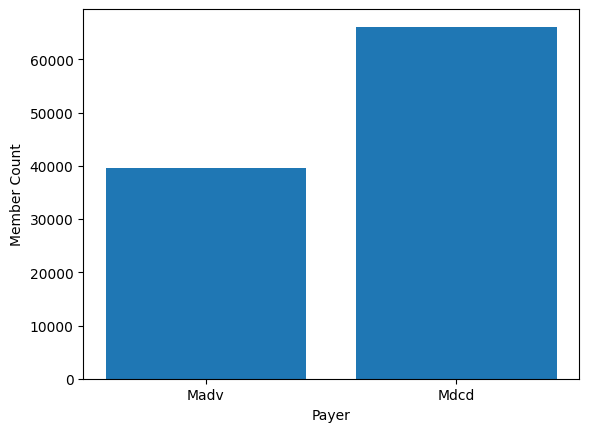

In [9]:
cur.execute('''
    SELECT payer, COUNT(*) AS count
    FROM std_member_info
    GROUP BY payer
''')
payer_breakdown = cur.fetchall()
print('Breakdown of members by payer:')
for payer in payer_breakdown:
    print(payer[0], ':', payer[1])

# Visualization - a bar chart of member counts by payer
query = 'SELECT payer, COUNT(*) FROM std_member_info GROUP BY payer;'
cur.execute(query)
result_set = cur.fetchall()

import matplotlib.pyplot as plt

x = [row[0] for row in result_set]
y = [row[1] for row in result_set]

plt.bar(x, y)
plt.xlabel('Payer')
plt.ylabel('Member Count')
plt.show()

# **Question 4:** How many members live in a zip code with a food_access_score lower than 2?

In [10]:
cur.execute('''
    SELECT COUNT(*) AS count
    FROM std_member_info AS smi
    JOIN model_scores_by_zip AS ms
    ON smi.zip = ms.zcta
    WHERE ms.food_access_score < 2
''')
low_food_access_zip_count = cur.fetchone()[0]
print('Number of members living in a zip code with a food_access_score lower than 2:', low_food_access_zip_count)

Number of members living in a zip code with a food_access_score lower than 2: 8127


# **Question 5:** What is the average social isolation score for the members?

In [11]:
cur.execute('''
    SELECT AVG(ms.social_isolation_score)
    FROM std_member_info AS smi
    JOIN model_scores_by_zip AS ms
    ON smi.zip = ms.zcta
''')
average_social_isolation_score = round(cur.fetchone()[0], 2)
print('Average social isolation score for the members:', average_social_isolation_score)

Average social isolation score for the members: 3.07


# **Question 6:** Which members live in the zip code with the highest algorex_sdoh_composite_score?

In [12]:
cur.execute('''
    SELECT smi.member_id, smi.member_first_name, smi.member_last_name, smi.main_address, smi.payer, smi.zip, ms.algorex_sdoh_composite_score
    FROM std_member_info AS smi
    JOIN model_scores_by_zip AS ms
    ON smi.zip = ms.zcta
    WHERE ms.algorex_sdoh_composite_score = (
        SELECT MAX(algorex_sdoh_composite_score)
        FROM model_scores_by_zip
    )
''')
members_highest_composite_score = cur.fetchall()
print('Members who live in the zip code with the highest algorex_sdoh_composite_score:')

with open('high_sdoh_members.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Member ID', 'Name', 'Address', 'Payer', 'Zip Code','Composite Score'])
    
    for member in members_highest_composite_score:
        writer.writerow([member[0], member[1] + ' ' + member[2], member[3], member[4],member[5], member[6]])
# Convert to pandas dataframe
df = pd.DataFrame(members_highest_composite_score, columns=['Member ID', 'First Name', 'Last Name', 'Address', 'Payer', 'Zip Code', 'Composite Score'])
df

Members who live in the zip code with the highest algorex_sdoh_composite_score:


,Member ID,First Name,Last Name,Address,Payer,Zip Code,Composite Score
0,15404143,Ruth,Engelhart,4592 Robert Crest,Madv,95950,8.77
1,15418054,Albert,Delay,124 Regina Ports Apt. 256,Madv,95950,8.77
2,15537550,Marie,Lund,590 Miller Plains,Madv,95950,8.77
3,15391076,Wilma,Mcauley,70237 Derek Manor,Mdcd,95950,8.77
4,15363143,Timothy,Reed,552 Sara Mission Suite 917,Mdcd,95950,8.77
5,15375855,Cecil,Redman,194 Sean Village Suite 890,Mdcd,95950,8.77
6,15456560,Thomas,Falcon,8764 Waller Underpass Apt. 396,Madv,95950,8.77
7,15462579,Tina,Davis,988 Brown Manor,Madv,95950,8.77
8,15340102,Elizabeth,Clark,572 Janet Trail,Mdcd,95950,8.77
9,15346807,Jeremy,Shelpman,901 Deborah Square,Madv,95950,8.77


### Count of each Payer for members who live in the zip code with the highest algorex_sdoh_composite_score

In [13]:
cur.execute('''SELECT smi.payer, COUNT(*) AS num_members
FROM std_member_info AS smi
JOIN model_scores_by_zip AS ms
ON smi.zip = ms.zcta
WHERE ms.algorex_sdoh_composite_score = (
    SELECT MAX(algorex_sdoh_composite_score)
    FROM model_scores_by_zip
)
GROUP BY smi.payer''')
sdoh_payer_count=cur.fetchall()
print('Count of each Payer for members who live in the zip code with the highest algorex_sdoh_composite_score:\n', sdoh_payer_count)

Count of each Payer for members who live in the zip code with the highest algorex_sdoh_composite_score:
 [('Madv', 23), ('Mdcd', 26)]
